In [2]:
import torch
import torchvision
import torch.nn as nn
from glob import glob
from platform import processor
import os
from models.unet import *
from loader.filesets import bouget21
from loader.meteonet import MeteonetDataset
from loader.samplers import meteonet_random_oversampler, meteonet_sequential_sampler
from torch.utils.data import DataLoader
from tqdm import tqdm
from os.path import join
import argparse
import matplotlib.pyplot as plt
from models.trajGRU import *
from models.refnet import *
from torchvision.transforms.functional import to_pil_image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torchvision import utils
from matplotlib import colors
import random
from loader.utilities import *
import pandas as pd


IN_LEN = 10
OUT_LEN= 5
STRIDE = IN_LEN


In [3]:
x = torch.load("./test_input_5", map_location='cpu')['x']
y = torch.load("./test_truth_5")['truth']
output = torch.load("./test_output_5", map_location='cpu')['y']
refoutput = torch.load("./test_refoutput_5", map_location='cpu')
refoutput = refoutput + x[:, 5:, None, :, :,].transpose(1,0)
print("input:    ", x.size())
print("truth:    ", y.size())
print("output:   ", output.size())
print("refoutput:", refoutput.size())

input:     torch.Size([128, 10, 128, 128])
truth:     torch.Size([128, 128, 128])
output:    torch.Size([5, 128, 1, 128, 128])
refoutput: torch.Size([5, 128, 1, 128, 128])


---

In [4]:
refnet = RefNet(1)
refnet.load_state_dict(torch.load("./runs_2s/model_refnet_5bis.pt", map_location='cpu'))
refnet.eval()
print(".")

.


/Users/jzhang/opt/anaconda3/lib/python3.9/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [5]:
cmap = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 
                                  'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                                  'khaki','burlywood','orange','brown','pink','red','plum'])
bounds = [-1,0,2,4,6,8,10,15,20,25,30,35,40,45,50,55,60,65,75]
norm = colors.BoundaryNorm(bounds, cmap.N)


In [6]:
output.size()

torch.Size([5, 128, 1, 128, 128])

In [7]:
indx = random.randint(0,128)
print("n°",indx)
a_batch = x[indx][:, None, :, :,]
print("1 batch (x) :", a_batch.size())
a_truth = y[indx][None, :, :,]
print("1 truth (y) :", a_truth.size())
a_output = output[:, indx, :, :,]
print("1 output (ŷ):", a_output.size())
a_refoutput = refnet(a_output)
print("1 ref_output:", a_output.size())

n° 3
1 batch (x) : torch.Size([10, 1, 128, 128])
1 truth (y) : torch.Size([1, 128, 128])
1 output (ŷ): torch.Size([5, 1, 128, 128])
1 ref_output: torch.Size([5, 1, 128, 128])


In [8]:
target = a_truth[0]
first_pred = a_output[-1][0]
second_pred = (a_batch[5:] + a_refoutput)[-1][0]

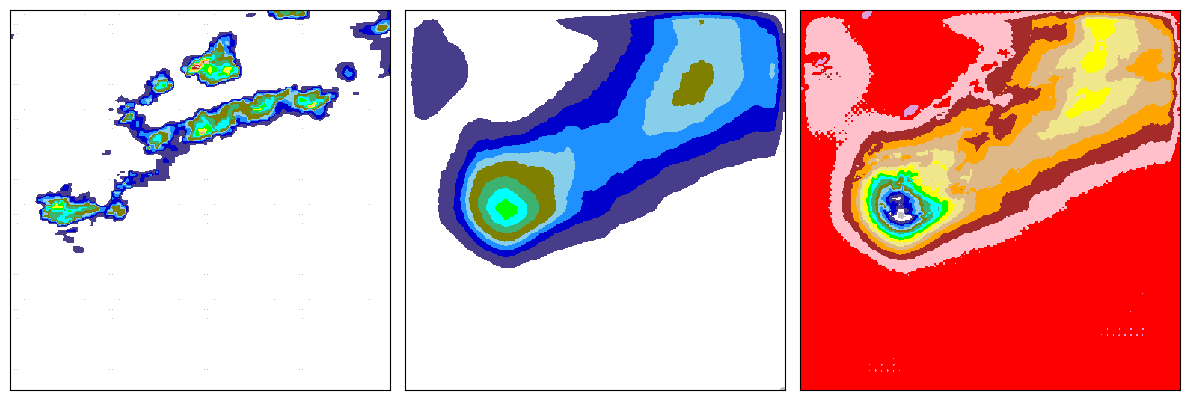

In [9]:
fig = plt.figure(figsize=(12,12), layout='tight')
fig.add_subplot(131)
plt.imshow(target, cmap=cmap, norm=norm)
plt.xticks([], [])
plt.yticks([], [])
fig.add_subplot(132)
plt.imshow(first_pred.detach().numpy(), cmap=cmap, norm=norm)
plt.xticks([], [])
plt.yticks([], [])
fig.add_subplot(133)
plt.imshow(second_pred.detach().numpy(), cmap=cmap, norm=None)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

---

In [31]:
thres = 0.6

bin_y = (F.sigmoid(y)>thres).int()
bin_output = (F.sigmoid(output)>thres)[-1, :, 0, :, :,].int()
bin_refoutput = (F.sigmoid(refoutput)>thres)[-1, :, 0, :, :,].int()

In [32]:
def get_CT(y, pred):
    diff = 2*pred - y
    TP = torch.sum(diff==1).unsqueeze(0)
    FP = torch.sum(diff==2).unsqueeze(0)
    FN = torch.sum(diff==-1).unsqueeze(0)
    TN = torch.sum(diff==0).unsqueeze(0)
    return torch.cat((TP, FP, FN, TN), dim=0)

In [33]:
def get_BS(CT, scores):
    TP, FP, FN, TN = CT.to('cpu')

    scores_values = []

    precis = TP/(TP+FP)  # c'est le POD d'Aniss
    recall = TP/(TP+FN)
    n = TP+TN+FP+FN

    for sc in scores:
        if sc == 'Precision':
            scores_values.append(precis) # POD
        elif sc == 'Recall':
            scores_values.append(recall)
        elif sc == 'F1':
            scores_values.append(2*precis*recall/(precis+recall+1e-10))
        elif sc == 'TS':
            scores_values.append(TP/(TP+FP+FN))  # CSI, FMS 
        elif sc == 'BIAS':
            scores_values.append((TP+FP)/(TP+FN))  
        elif sc == 'HSS':  # alternative definition, see Hogan 2009
            n = TP+TN+FP+FN 
            rc = ((TP+FP)*(TP+FN) + (TN+FP)*(TN+FN))/n
            scores_values.append( (TP+TN-rc)/(n-rc))
        elif sc == 'FAR':
            scores_values.append( FP / (FP+TN))
        elif sc == 'Accuracy': 
            scores_values.append( (TP+TN) / n)
        elif sc == 'ETS':
            TP_r = (TP+FN)*(TP+FP) / n
            scores_values.append( (TP-TP_r)/(TP+FP+FN-TP_r))
        elif sc == 'ORSS':
            scores_values.append( (TP*TN - FP*FN)/(TP*TN + FP*FN))
        else:
            print(f'score {sc} unkown')

    return np.array([scv.numpy() for scv in scores_values])

In [34]:
print(get_CT(bin_y, bin_output))

tensor([ 227070,  739577,   14471, 1116034])


In [35]:
scores = ['Precision', 'Recall', 'F1','TS','BIAS','HSS','FAR','Accuracy','ETS','ORSS']
pd.DataFrame(get_BS(get_CT(bin_y, bin_output), scores), index=scores)

,0
Precision,0.234905
Recall,0.940089
F1,0.375885
TS,0.231440
BIAS,4.002000
HSS,0.234873
FAR,0.398563
Accuracy,0.640442
ETS,0.133063
ORSS,0.918958


In [36]:
pd.DataFrame(get_BS(get_CT(bin_y, bin_refoutput),scores), index=scores)

,0
Precision,0.682011
Recall,0.400971
F1,0.505025
TS,0.337815
BIAS,0.587925
HSS,0.458874
FAR,0.024335
Accuracy,0.909474
ETS,0.297753
ORSS,0.928152


n° 4
1 truth (y) : torch.Size([128, 128])
1 output (ŷ): torch.Size([128, 128])
1 ref_output: torch.Size([128, 128])


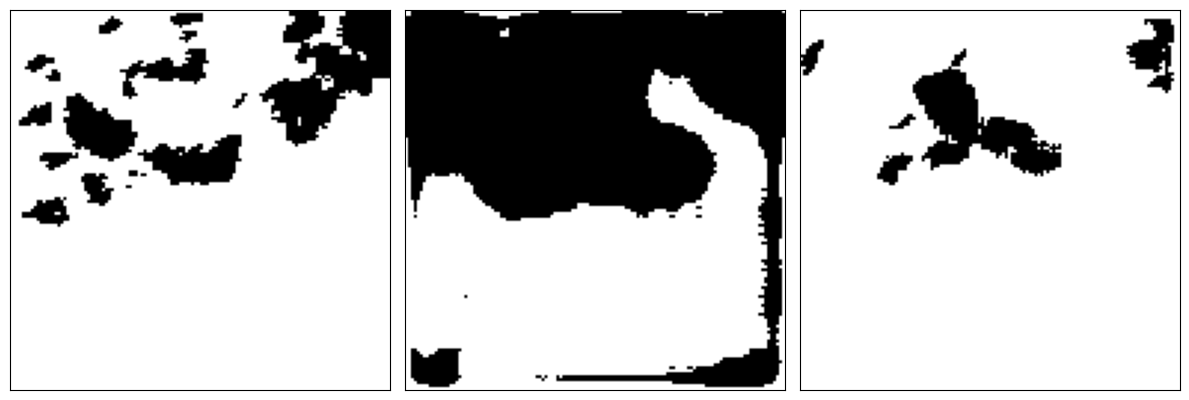

In [57]:
indx = random.randint(0,127)
print("n°",indx)
a_truth = bin_y[indx]
print("1 truth (y) :", a_truth.size())
a_output = bin_output[indx]
print("1 output (ŷ):", a_output.size())
a_refoutput = bin_refoutput[indx]
print("1 ref_output:", a_output.size())
fig = plt.figure(figsize=(12,12), layout='tight')
fig.add_subplot(131)
plt.imshow(a_truth, cmap='binary')
plt.xticks([], [])
plt.yticks([], [])
fig.add_subplot(132)
plt.imshow(a_output, cmap='binary')
plt.xticks([], [])
plt.yticks([], [])
fig.add_subplot(133)
plt.imshow(a_refoutput, cmap='binary')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [18]:
# indx_range = random.sample(range(128), 10)
# for indx in indx_range:
#     a_truth = bin_y[indx]
#     a_output = bin_output[indx]
#     a_refoutput = bin_refoutput[indx]
#     fig = plt.figure(figsize=(12,12), layout='tight')
#     fig.add_subplot(131)
#     plt.imshow(a_truth, cmap='binary')
#     plt.xticks([], [])
#     plt.yticks([], [])
#     fig.add_subplot(132)
#     plt.imshow(a_refoutput, cmap='binary')
#     plt.xticks([], [])
#     plt.yticks([], [])
#     plt.savefig("./res_ref5/"+str(indx), bbox_inches='tight')
#     plt.show()